<a href="https://colab.research.google.com/github/viviakemik/machine-learning/blob/main/classification/classification_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Book: 

* Hands-on Machine Learning with Scikit-learn & TensorFlow

https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646

2. Github: https://github.com/ageron/handson-ml2

3. Courses: 
* https://www.coursera.org/learn/machine-learning
* https://www.coursera.org/learn/ml-classification/home
* https://learning.edx.org/course/course-v1:UCSanDiegoX+DSE220x+1T2021/home

4. Youtube:
* https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw
         

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# **MNIST**

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

(784,)
(784,)


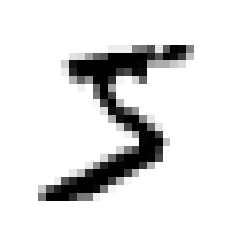

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print(some_digit.shape)
some_digit_image = some_digit.reshape(28, 28)
print(some_digit.shape)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

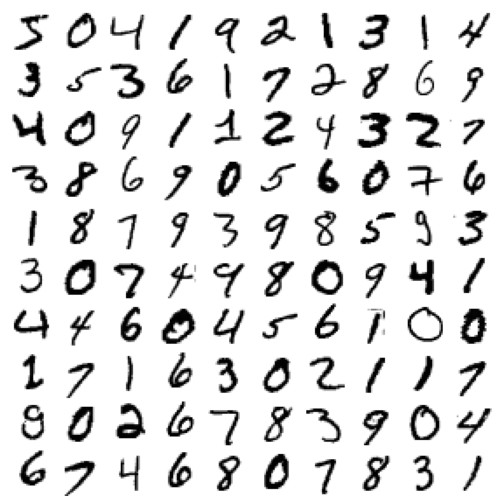

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [10]:
y[0]

5

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# **Training a Binary Classifier**

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5 (classifier, capable of
distinguishing between just two classes, 5 and not-5)

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGD has the advantage of being capable of handling very large datasets efficiently.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# **Performance Measures**

StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


cross-validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
#dumb classifier that just classifies every single image in the “not-5” class:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates **why accuracy is generally not the preferred performance** measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).



## **Confusion Matrix**

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).


cross_val_predict() performs K-fold cross-validation

https://www.youtube.com/watch?v=Kdsp6soqA7o

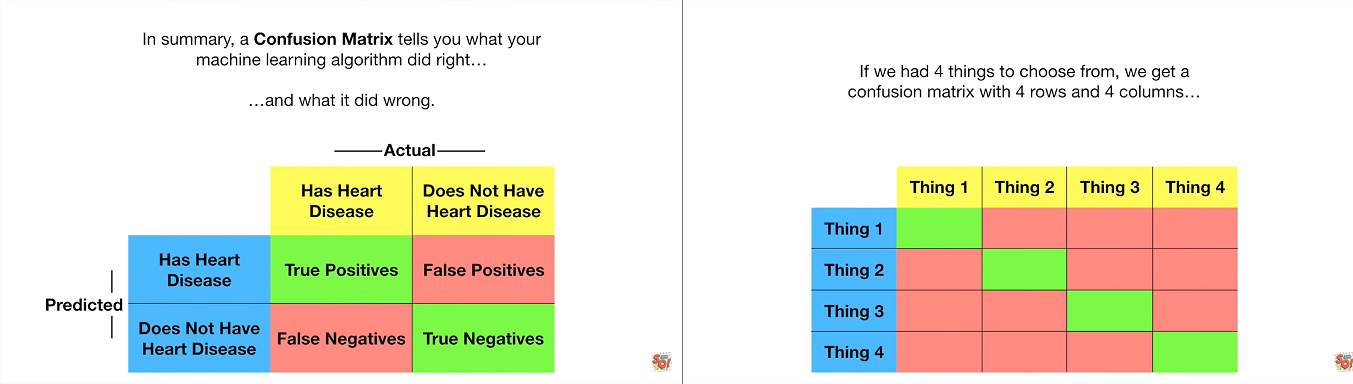

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## **Precision and Recall**

* Precision: proportion of positive results that were correctly classified
* Recall: proportion of actual positives that were identified correctly


Image from https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646

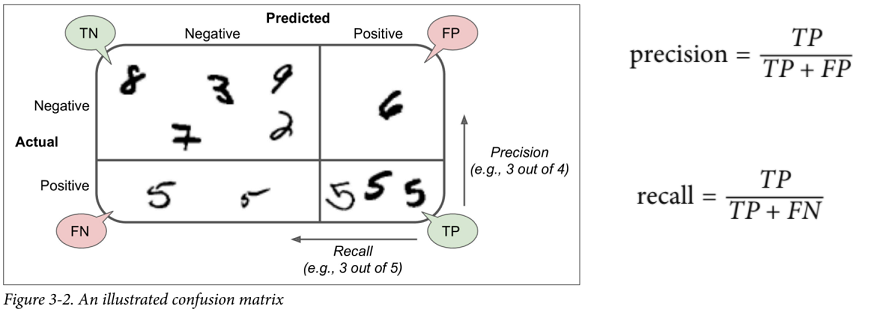

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
#same as precision_score
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
#same as recall_score

cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers.

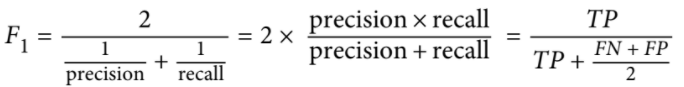

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
#same as f1_score

cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### **Precision/Recall Tradeoff**

in **some contexts** you mostly care about **precision**, and in other contexts you really care about **recall**. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product.

score based on a **decision function**, and if that score is greater than a **threshold**, it assigns the instance to the positive class, or else it assigns it to the negative class.

Image from https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646

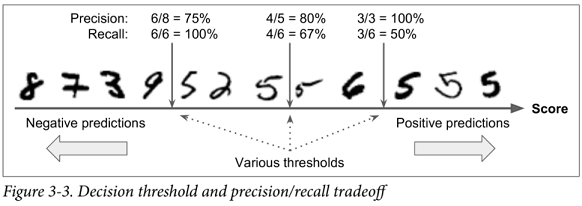

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
#SGDClassifier uses a threshold equal to 0

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
# raise a threshold

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Now how do you decide which threshold to use? For this you will first need to **get the scores of all instances** in the training set using the **cross_val_predict()** function again, but this time specifying that you want it to return decision scores instead of predictions:

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

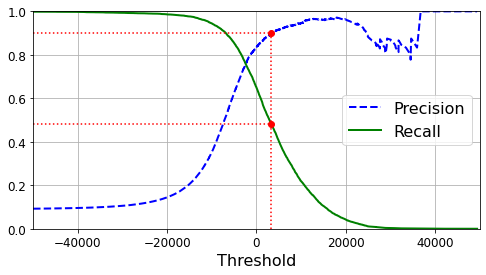

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall

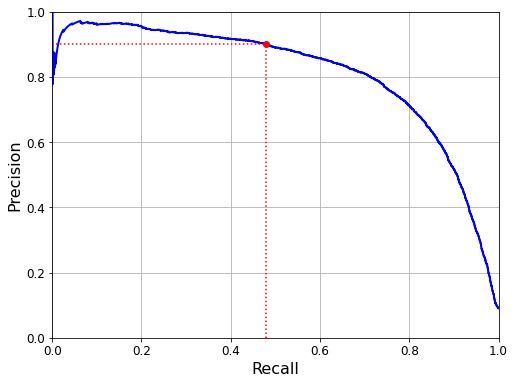

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop.

So let’s suppose you decide to aim for 90% precision.

In [35]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [36]:
threshold_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

A high-precision classifier is not very useful if its recall is too low

## **The ROC Curve**

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.

https://www.youtube.com/watch?v=vP06aMoz4v8


* Sensitivity (Recall): % with heart disease were correctly identified by the model
* Specificity: % without heart disease were correctly identified by the model

What measure is more important to your problem?

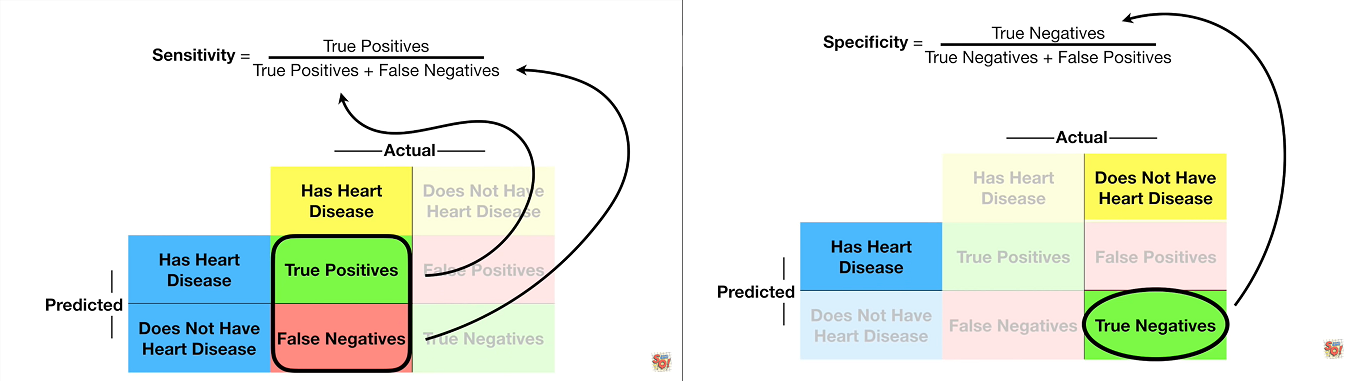

https://www.youtube.com/watch?v=4jRBRDbJemM

If there were lots of samples that were not obese, then Precision might be more useful than False Positive Rate


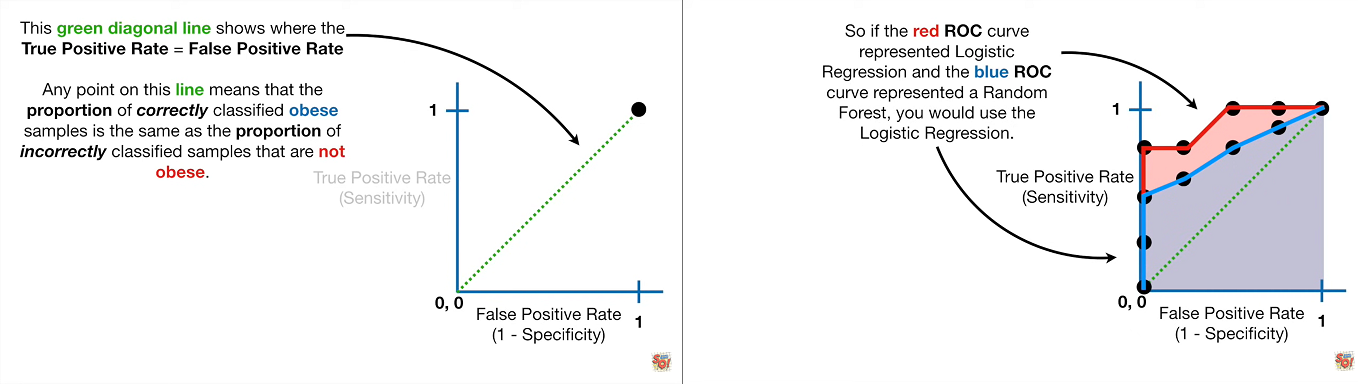



In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

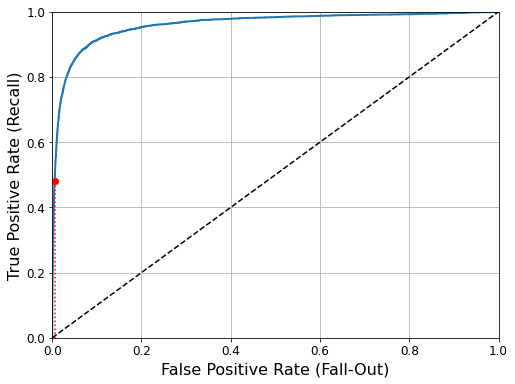

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()

The **dotted line** represents the ROC curve of a **purely random classifier**; a **good classifier** stays as far away from that line as possible (toward the **top-left corner**).

PR (Precision x Recall) curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier class does not have a decision_function() method. Instead it has a **predict_proba()** (returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class)

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [44]:
# to plot roc curve you need scores not probabilities
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

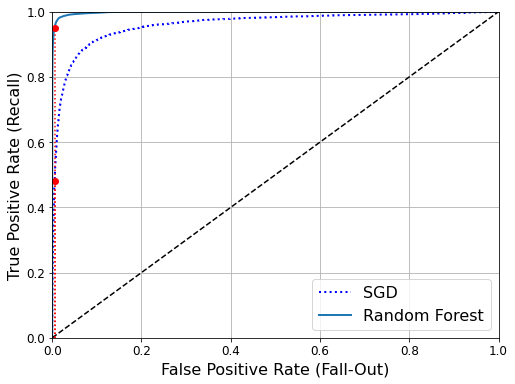

In [45]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# **Multiclass Classication**

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are **various strategies that you can use to perform multiclass classification using multiple binary classifiers**.

* OvA: one-versus-all
* OvO: one-versus-one, Ex: train a binary classifier for every pair of digits (For the MNIST problem, this means training 45 binary classifiers!).

https://www.coursera.org/learn/machine-learning

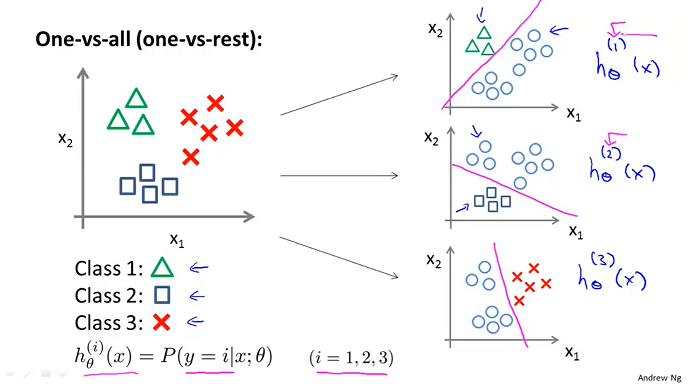

SVM preferred OvO since it is faster to train many classifiers on small training sets than training few classifiers on large training sets.

In [49]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
svm_clf.classes_[5]

5

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [54]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [55]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes.

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [58]:
len(ovr_clf.estimators_)

10

Scikit-Learn did not have to run OvA or OvO because Random Forest
classifiers can directly classify instances into multiple classes.

In [59]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

You can see that the classifier is fairly confident about its prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5.

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

simply scaling the inputs increases accuracy above 89%

# **Error Analysis**

we will assume that you have found a promising model and you want
to find ways to improve it. One way to do this is to analyze the types of errors it makes.

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

It’s often more convenient to look at an image representation
of the confusion matrix, using Matplotlib’s matshow() function:

In [63]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

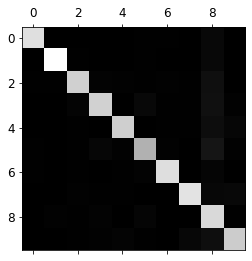

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

This confusion matrix looks fairly good, since most images are on the main **diagonal**, which means that they were **classified correctly**. The 5s look **slightly darker** than the other digits, which could mean that there are **fewer images** of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class,

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors

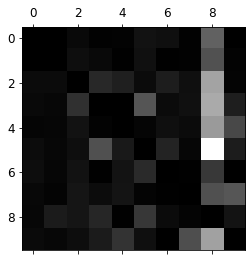

In [66]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is **quite bright**, which tells you that many images get **misclassified** as 8s. You can also see that 3s and 5s often get confused.

* you could try to gather more training data for digits that
look like 8s (but are not)

* Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). 

* Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing the confusion matrix can often give you insights on ways to improve your classifier.

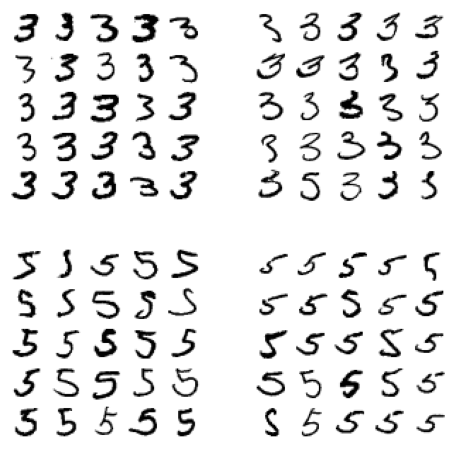

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them.

So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated.

# **Multilabel Classication**

In some cases you may want your classifier to output multiple classes for each instance.

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd.

In [69]:
knn_clf.predict([some_digit])

array([[False,  True]])

one approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

This assumes that all labels are equally important. If you want to give each label a weight, simply set average="weighted"

In [70]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# **Multioutput Classication**

generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

It will take as input a noisy digit image, and it will (hopefully) output a clean digit image. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). **The line between classification and regression is sometimes blurry**

adding noise to their pixel intensities

In [71]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [73]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

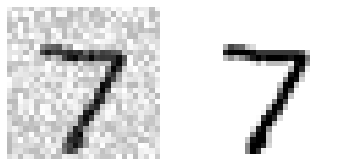

In [74]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

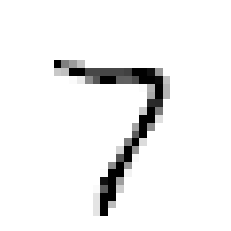

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")

# **Exercises**

## **1.**

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=16.6min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.6min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=16.5min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 33.1min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=16.5min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=16.5min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=16.5min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=16.5min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=16.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=16.5min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=16.5min
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 498.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [79]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [80]:
grid_search.best_score_

0.9716166666666666

In [81]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## **2.**

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.


In [82]:
from scipy.ndimage.interpolation import shift

In [83]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

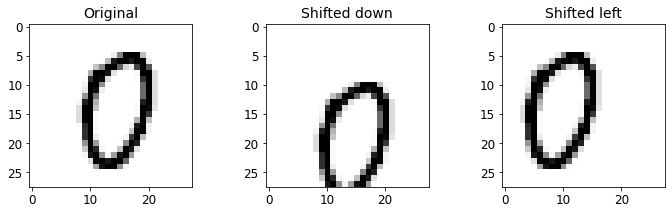

In [84]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [85]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [86]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [87]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [88]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

## **3.**

Tackle the Titanic dataset

Submmited on Kaggle